### Subtract background from PostISRCCD Example

In [1]:
import lsst.daf.persistence as dafPersist
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
butlerNoInterp = dafPersist.Butler("/datasets/hsc/repo/rerun/private/czw/DM-17471/noInterp.20190328")
butler = dafPersist.Butler("/datasets/hsc/repo/rerun/private/czw/DM-17471/yesInterp.20190328")

In [2]:
# Get data products
dataId = {"visit": 902900, "ccd": 16}
calexp = butler.get('calexp', dataId=dataId)
background = butler.get('calexpBackground', dataId=dataId)
preInterpExp = butlerNoInterp.get('postISRCCD', dataId=dataId)

In [3]:
# Subtract the good background from the preInterExposure
mi = preInterpExp.maskedImage
mi -= background.getImage()

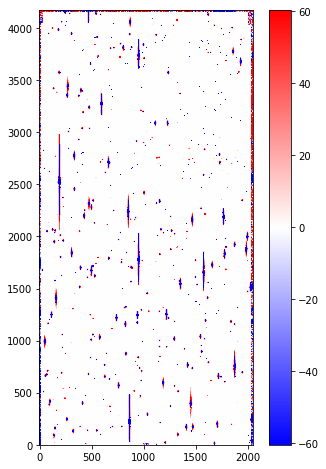

In [4]:
# Plot
fig = plt.figure(figsize=(6,8))
arr = calexp.image.getArray() - preInterpExp.image.getArray()
vmin, vmax = np.percentile(arr, (1, 99))
spread = min(np.abs(vmin), np.abs(vmax))
plt.imshow(calexp.image.getArray() - preInterpExp.image.getArray(), origin='lower', 
           vmin=-spread, vmax=spread, cmap="bwr")
plt.colorbar()

In [5]:
# Write the diff as fits. This modifies `preInterpExp`
mi -= calexp.getMaskedImage()
preInterpExp.writeFits('diff.fits')